In [1]:
%cd ..
%pip install -e .

/home/sandor/dtu/2021-22-spring/advanced_machine_learning/p-reg
Obtaining file:///home/sandor/dtu/2021-22-spring/advanced_machine_learning/p-reg
  Preparing metadata (setup.py) ... done
  Attempting uninstall: src
    Found existing installation: src 0.1.0
    Uninstalling src-0.1.0:
      Successfully uninstalled src-0.1.0
  Running setup.py develop for src
Note: you may need to restart the kernel to use updated packages.


In [5]:
import random

import numpy as np
import pandas as pd

from src.models.gcn import GCN_fix_2layer
from src.models.gcn import GCN_fix_3layer
from src.models.gcn import GCN_fix_4layer

from src.models.train_model import train_with_loss
from src.models.train_model import random_splits

from src.models.reg import make_preg_ce_ce_alt
from src.models.reg import compute_a_hat

from src.models.evaluate_model import evaluate1

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from sklearn.manifold import TSNE

from src.models.evaluate_model import test
from tqdm import tqdm


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=T.NormalizeFeatures())
data = dataset[0].to(device)

A_hat = compute_a_hat(data)

data.reg_mask = torch.ones_like(data.train_mask, dtype=torch.bool)

In [7]:
print('-------------------------------------------------------------')
print(f'train size: {data.train_mask.sum()}')
print(f'val size: {data.val_mask.sum()}')
print(f'test size: {data.test_mask.sum()}')
print('-------------------------------------------------------------')

metrics = []

for num_layers in [2, 3, 4]:
    for mu in [.0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1.]:
        torch.manual_seed(1)
        random.seed(1)

        loss_fn = make_preg_ce_ce_alt(mu, A_hat)

        if num_layers == 2:
            model = GCN_fix_2layer()
        elif num_layers == 3:
            model = GCN_fix_3layer()
        elif num_layers == 4:
            model = GCN_fix_4layer()
        else:
            raise NotImplementedError   

        model = train_with_loss(model, data, loss_fn, num_epochs=200)

        train_acc, val_acc, test_acc = evaluate1(model, data)
        metrics.append({'num_layers': num_layers, 'mu': mu, 'train_acc': np.round(train_acc,4), 'val_acc': np.round(val_acc,4), 'test_acc': np.round(test_acc,4)})
        print(metrics[-1])

-------------------------------------------------------------
train size: 140
val size: 500
test size: 1000
-------------------------------------------------------------
{'num_layers': 2, 'mu': 0.0, 'train_acc': 1.0, 'val_acc': 0.784, 'test_acc': 0.8}
{'num_layers': 2, 'mu': 0.1, 'train_acc': 1.0, 'val_acc': 0.794, 'test_acc': 0.817}
{'num_layers': 2, 'mu': 0.2, 'train_acc': 0.9929, 'val_acc': 0.802, 'test_acc': 0.822}
{'num_layers': 2, 'mu': 0.3, 'train_acc': 0.9929, 'val_acc': 0.802, 'test_acc': 0.821}
{'num_layers': 2, 'mu': 0.4, 'train_acc': 0.9929, 'val_acc': 0.806, 'test_acc': 0.819}
{'num_layers': 2, 'mu': 0.5, 'train_acc': 0.9929, 'val_acc': 0.806, 'test_acc': 0.821}
{'num_layers': 2, 'mu': 0.6, 'train_acc': 0.9929, 'val_acc': 0.802, 'test_acc': 0.821}
{'num_layers': 2, 'mu': 0.7, 'train_acc': 0.9929, 'val_acc': 0.724, 'test_acc': 0.768}
{'num_layers': 2, 'mu': 0.8, 'train_acc': 0.9571, 'val_acc': 0.518, 'test_acc': 0.521}
{'num_layers': 2, 'mu': 0.9, 'train_acc': 0.9286, 'val_

In [8]:
df = pd.DataFrame(metrics)
df[df['mu']==.3]

,num_layers,mu,train_acc,val_acc,test_acc
3,2,0.3,0.9929,0.802,0.821
14,3,0.3,1.0000,0.812,0.818
25,4,0.3,0.1429,0.122,0.130


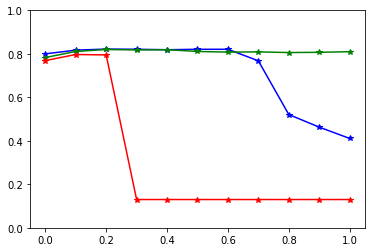

In [11]:
df = pd.DataFrame(metrics)
fig, ax = plt.subplots()

filt = (df['num_layers'] == 2)
ax.plot(df[filt]['mu'], df[filt]['test_acc'], '-*b')

filt = (df['num_layers'] == 3)
ax.plot(df[filt]['mu'], df[filt]['test_acc'], '-*g')

filt = (df['num_layers'] == 4)
ax.plot(df[filt]['mu'], df[filt]['test_acc'], '-*r')

ax.set(ylim=(.0, 1.))
plt.show()